In [28]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import noisereduce as nr
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
tqdm.pandas()

# GridSearchMFCC

In [3]:
def read_audio(path):
    audio, sample_rate = librosa.load(path, sr=44100)
    return audio

In [4]:
manifest = pd.read_excel('manifest_balanced.xlsx')
variants = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
manifest = manifest[manifest['Variant'].isin(variants)]
manifest = manifest[['path', 'Variant', 'text', 'informant']]
manifest['audio'] = manifest['path'].progress_apply(read_audio)

100%|████████████████████████████████████████████████████████████████████████████| 25806/25806 [08:05<00:00, 53.10it/s]


In [7]:
manifest = manifest[['path', 'Variant', 'audio', 'informant']]
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
variants = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
for variant in variants:
    speaker_counts = manifest[manifest['Variant']==variant]['informant'].value_counts().to_dict()
    total_records = len(manifest[manifest['Variant']==variant]['path'])
    train_target = 0.7 * total_records
    val_target = 0.165 * total_records
    test_target = total_records - train_target - val_target
    speaker_ids = list(speaker_counts.keys())
    train_speakers, val_speakers, test_speakers = [], [], []
    train_sum = val_sum = test_sum = 0
    for speaker in speaker_ids:
        count = speaker_counts[speaker]
        if train_sum + count <= train_target:
            train_speakers.append(speaker)
            train_sum += count
        elif val_sum + count <= val_target:
            val_speakers.append(speaker)
            val_sum += count
        else:
            test_speakers.append(speaker)
            test_sum += count
    train_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(train_speakers))]
    valid_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(val_speakers))]
    test_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(test_speakers))]
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['audio'].str.len()>0]
valid = valid[valid['audio'].str.len()>0]
test = test[test['audio'].str.len()>0]

Define class for MFCC to be able to create MFCC + delta + delta-delta

In [8]:
class MFCC(BaseEstimator, TransformerMixin):
    def __init__(self, sr=44100, n_mfcc=10):
        self.sr = sr
        self.n_mfcc = n_mfcc

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = []
        for x in tqdm(X):
            mfcc = librosa.feature.mfcc(y=x, sr=self.sr, n_mfcc=self.n_mfcc)
            delta = librosa.feature.delta(mfcc)
            delta2 = librosa.feature.delta(mfcc, order=2)
            combined = np.vstack([mfcc, delta, delta2])
            features.append(np.mean(combined, axis=1))
        return np.array(features)

In [9]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=10)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2'))
])

param_grid = {
    'mfcc__n_mfcc': [13, 20, 40],
    'clf__C': [0.1, 1, 10],
    'clf__class_weight': ['balanced']
}

gs = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_macro')
gs.fit(train['audio'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 17347/17347 [06:00<00:00, 48.14it/s]


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('mfcc', MFCC()),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LinearSVC(dual=False,
                                                  max_iter=10000))]),
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__class_weight': ['balanced'],
                         'mfcc__n_mfcc': [13, 20, 40]},
             scoring='f1_macro')

In [10]:
gs_result = pd.concat([pd.DataFrame(gs.cv_results_["params"]), 
                       pd.DataFrame(gs.cv_results_["mean_test_score"], columns=["f1_macro"])],axis=1)

In [11]:
gs_result

,clf__C,clf__class_weight,mfcc__n_mfcc,f1_macro
0,0.1,balanced,13,0.728436
1,0.1,balanced,20,0.779249
2,0.1,balanced,40,0.810527
3,1.0,balanced,13,0.730400
4,1.0,balanced,20,0.780289
5,1.0,balanced,40,0.813184
6,10.0,balanced,13,0.730608
7,10.0,balanced,20,0.780509
8,10.0,balanced,40,0.813846


In [12]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 17347/17347 [06:10<00:00, 46.76it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

In [13]:
print(classification_report(test['Variant'], pipe.predict(test['audio'])))

100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [01:46<00:00, 37.56it/s]

               precision    recall  f1-score   support

Arkhangelskie       0.69      0.97      0.81       577
 Novgorodskie       0.49      0.29      0.36       606
    Povolzkie       0.97      0.90      0.93      1278
    Pskovskie       0.65      0.80      0.72       980
   Ryazanskie       0.68      0.52      0.59       549

     accuracy                           0.74      3990
    macro avg       0.69      0.69      0.68      3990
 weighted avg       0.74      0.74      0.73      3990



100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [01:46<00:00, 37.58it/s]


<Figure size 3000x1800 with 0 Axes>

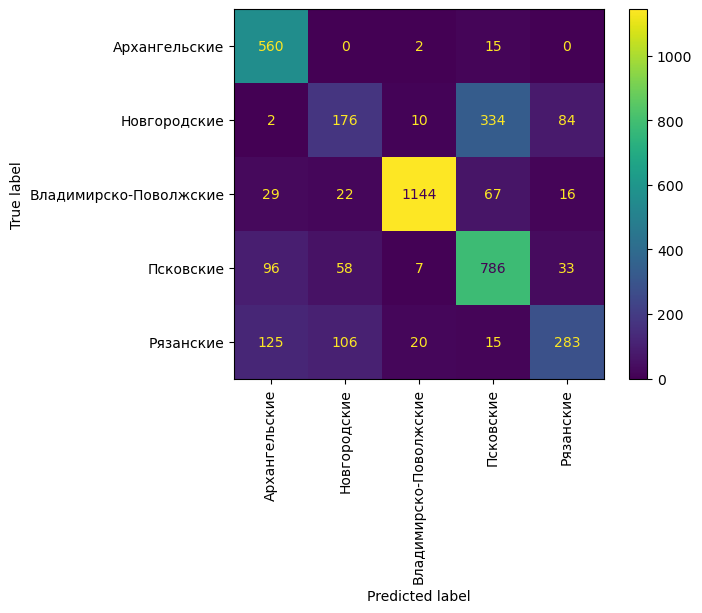

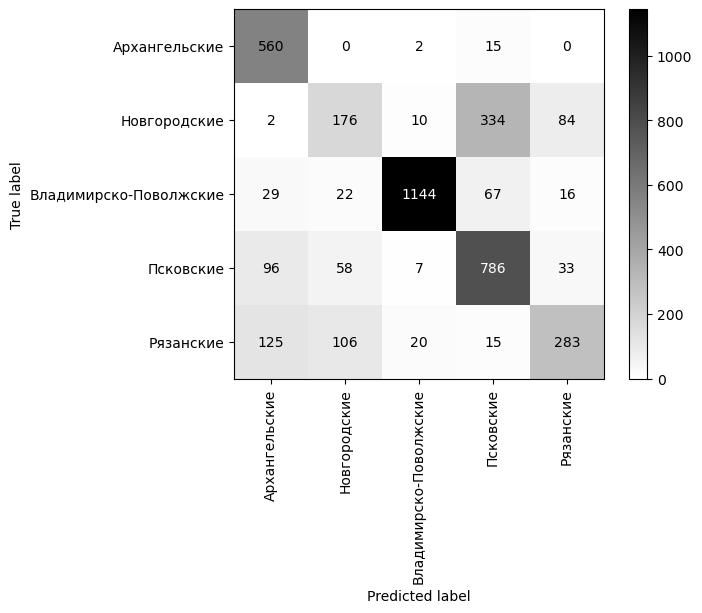

In [14]:
labs = ['Архангельские', 'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские']
plt.figure(figsize=(10, 6), dpi=300)
disp = ConfusionMatrixDisplay.from_predictions(test['Variant'], pipe.predict(test['audio']),
                                        display_labels = labs, xticks_rotation='vertical')
disp = disp.plot(cmap=plt.cm.binary,values_format='g',xticks_rotation='vertical')
plt.show()

# Test on data which not presented in dataset

In [29]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 17347/17347 [11:47<00:00, 24.51it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

## Yelets

In [30]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['predictions'] = pipe.predict(yelets['array'])
yelets['predictions'].value_counts()

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:57<00:00,  9.08it/s]


Ryazanskie       204
Arkhangelskie    159
Povolzkie        151
Pskovskie          8
Name: predictions, dtype: int64

## Pskov

In [31]:
path1 = './RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = './RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['predictions'] = pipe.predict(pskov_test_rnc_df['array'])
pskov_test_rnc_df['predictions'].value_counts()

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 25.13it/s]


Arkhangelskie    35
Pskovskie        23
Povolzkie        10
Name: predictions, dtype: int64

# With denoise

In [15]:
def denose_audio(audio):
    return nr.reduce_noise(y=audio, sr=44100)

In [20]:
manifest['audio_denoised'] = manifest['audio'].progress_apply(denose_audio)

100%|████████████████████████████████████████████████████████████████████████████| 25806/25806 [36:44<00:00, 11.71it/s]


In [21]:
manifest = manifest[['path', 'Variant', 'audio', 'audio_denoised', 'informant']]
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()
variants = ['Arkhangelskie', 'Novgorodskie', 'Povolzkie', 'Pskovskie', 'Ryazanskie']
for variant in variants:
    speaker_counts = manifest[manifest['Variant']==variant]['informant'].value_counts().to_dict()
    total_records = len(manifest[manifest['Variant']==variant]['path'])
    train_target = 0.7 * total_records
    val_target = 0.165 * total_records
    test_target = total_records - train_target - val_target
    speaker_ids = list(speaker_counts.keys())
    train_speakers, val_speakers, test_speakers = [], [], []
    train_sum = val_sum = test_sum = 0
    for speaker in speaker_ids:
        count = speaker_counts[speaker]
        if train_sum + count <= train_target:
            train_speakers.append(speaker)
            train_sum += count
        elif val_sum + count <= val_target:
            val_speakers.append(speaker)
            val_sum += count
        else:
            test_speakers.append(speaker)
            test_sum += count
    train_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(train_speakers))]
    valid_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(val_speakers))]
    test_df = manifest[(manifest['Variant']==variant)&(manifest['informant'].isin(test_speakers))]
    train = pd.concat([train, train_df])
    valid = pd.concat([valid, valid_df])
    test = pd.concat([test, test_df])
train = train[train['audio'].str.len()>0]
valid = valid[valid['audio'].str.len()>0]
test = test[test['audio'].str.len()>0]

In [22]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio_denoised'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 17347/17347 [11:42<00:00, 24.70it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

In [23]:
print(classification_report(test['Variant'], pipe.predict(test['audio_denoised'])))

100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [02:52<00:00, 23.19it/s]

               precision    recall  f1-score   support

Arkhangelskie       0.42      0.80      0.55       577
 Novgorodskie       0.57      0.25      0.35       606
    Povolzkie       0.90      0.83      0.86      1278
    Pskovskie       0.58      0.66      0.62       980
   Ryazanskie       0.38      0.23      0.29       549

     accuracy                           0.62      3990
    macro avg       0.57      0.56      0.54      3990
 weighted avg       0.63      0.62      0.60      3990



100%|██████████████████████████████████████████████████████████████████████████████| 3990/3990 [02:51<00:00, 23.20it/s]


<Figure size 3000x1800 with 0 Axes>

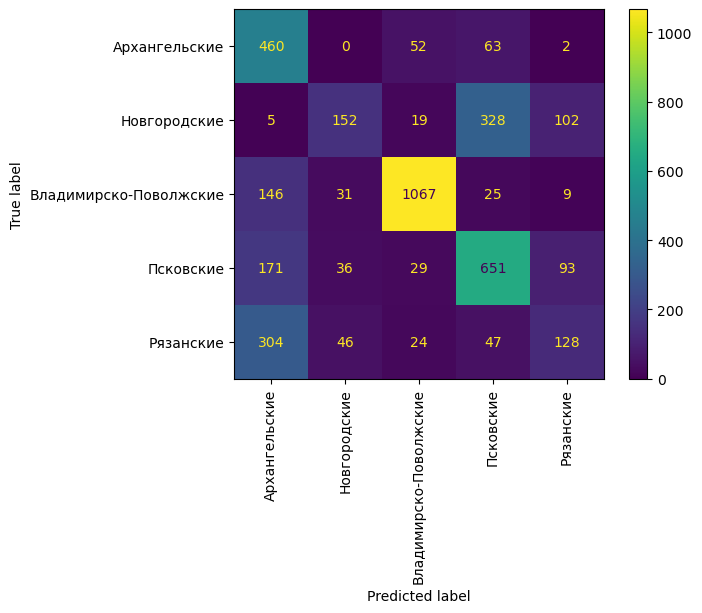

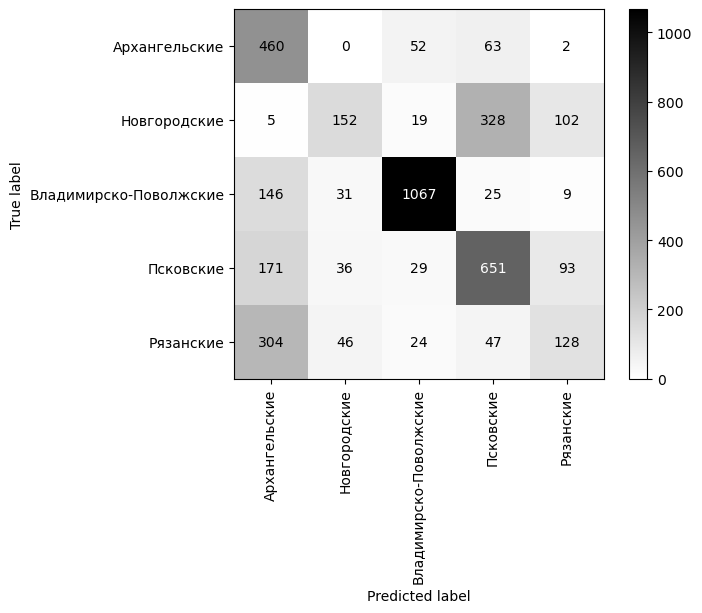

In [24]:
labs = ['Архангельские', 'Новгородские', 'Владимирско-Поволжские', 'Псковские', 'Рязанские']
plt.figure(figsize=(10, 6), dpi=300)
disp = ConfusionMatrixDisplay.from_predictions(test['Variant'], pipe.predict(test['audio_denoised']),
                                        display_labels = labs, xticks_rotation='vertical')
disp = disp.plot(cmap=plt.cm.binary,values_format='g',xticks_rotation='vertical')
plt.show()

# Test on data which not presented in dataset

In [32]:
pipe = Pipeline([
    ('mfcc', MFCC(n_mfcc=40)),
    ('scaler', StandardScaler()),
    ('clf', LinearSVC(max_iter=10000, dual=False, multi_class='ovr', loss='squared_hinge', penalty='l2', C=1))
])

train_y = train['Variant'].values.reshape(-1,1)
pipe.fit(train['audio_denoised'], train['Variant'].ravel())

100%|████████████████████████████████████████████████████████████████████████████| 17347/17347 [10:31<00:00, 27.46it/s]


Pipeline(steps=[('mfcc', MFCC(n_mfcc=40)), ('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, dual=False, max_iter=10000))])

## Yelets

In [33]:
yelets = pd.read_excel('manifest.xlsx')
yelets = yelets[yelets['corpus']=='Yelets']
yelets['Variant'] = 'Mezhzonalnie'
yelets = yelets[['path', 'Variant']]
yelets['array'] = yelets['path'].progress_apply(read_audio)
yelets['audio_denoised'] = yelets['array'].progress_apply(denose_audio)
yelets['predictions'] = pipe.predict(yelets['audio_denoised'])
yelets['predictions'].value_counts()

100%|████████████████████████████████████████████████████████████████████████████████| 522/522 [00:59<00:00,  8.76it/s]


Arkhangelskie    354
Ryazanskie        77
Povolzkie         70
Novgorodskie      12
Pskovskie          9
Name: predictions, dtype: int64

## Pskov

In [34]:
path1 = './RNC_Pskov/pskov_luch'
pskov1 = [join(path1, f) for f in listdir(path1) if isfile(join(path1, f))]
path2 = './RNC_Pskov/pskov_vedma'
pskov2 = [join(path2, f) for f in listdir(path2) if isfile(join(path2, f))]
pskov_test_rnc = pskov1 + pskov2
pskov_test_rnc_df = pd.DataFrame(pskov_test_rnc, columns=['path'])
pskov_test_rnc_df['Variant'] = 'Pskovskie'
pskov_test_rnc_df['array'] = pskov_test_rnc_df['path'].progress_apply(read_audio)
pskov_test_rnc_df['audio_denoised'] = pskov_test_rnc_df['array'].progress_apply(denose_audio)
pskov_test_rnc_df['predictions'] = pipe.predict(pskov_test_rnc_df['audio_denoised'])
pskov_test_rnc_df['predictions'].value_counts()

100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 23.56it/s]


Arkhangelskie    38
Povolzkie        19
Pskovskie        11
Name: predictions, dtype: int64